## Give Me Credit Simulations

for this set of experiments, you need to install the whynot package. Information can be found here: [whynot link](https://whynot.readthedocs.io/en/latest/simulators.html)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import whynot as wn
import whynot.gym as gym
from whynot.simulators.credit import CreditData

import utils

# %matplotlib inline

In [2]:
env = gym.make('Credit-v0')
env.seed(1)

base_dataset = env.initial_state.values()
base_features, base_labels = base_dataset["features"], base_dataset["labels"]
num_agents, num_features = base_features.shape
print(f"The dataset has {num_agents} agents and {num_features} features.")

The dataset has 18357 agents and 11 features.


In [3]:
l2_penalty = 1.0 / num_agents
baseline_theta = utils.fit_logistic_regression(base_features, base_labels, l2_penalty)
baseline_acc = ((base_features.dot(baseline_theta) > 0)  == base_labels).mean()
print(f"Baseline logistic regresion model accuracy: {100 * baseline_acc:.2f}%")

Baseline logistic regresion model accuracy: 72.08%


In [6]:
smoothness = np.sum(np.square(np.linalg.norm(base_features, axis=1))) / (4.0 * num_agents) + l2_penalty
print("Smoothness constant: {}".format(smoothness))

Smoothness constant: 4.666338139211646


In [7]:
def compute_grad_d_theta(features, labels, epsilon, theta, l2_penalty):
    n, d = np.shape(features)
    
    x_minus_epsilon_theta = features - (epsilon * theta)
    theta_x_minus_epsilon_theta = x_minus_epsilon_theta @ theta
    x_minus_two_epsilon_theta = features - 2 * epsilon * theta
    first_part = -labels[:, np.newaxis] * x_minus_two_epsilon_theta
    second_part = (1 - np.reciprocal(1 + np.exp(theta_x_minus_epsilon_theta)))[:, np.newaxis] * x_minus_two_epsilon_theta
    return 1.0/n * np.sum(first_part + second_part, axis=0) + l2_penalty * theta

In [8]:
def evaluate_loss_at_d_theta(theta, epsilon, features, labels, l2_penalty):
    n, d = np.shape(features)
    
    x_minus_epsilon_theta = features - (epsilon * theta)
    theta_x_minus_epsilon_theta = x_minus_epsilon_theta @ theta
    first_part = -labels @ theta_x_minus_epsilon_theta
    second_part = np.sum(np.log(1 + np.exp(theta_x_minus_epsilon_theta)))
    return 1.0/n * (first_part + second_part) + l2_penalty / 2 * (theta @ theta)

In [9]:
def compute_po_point(epsilon, features, labels, l2_penalty=l2_penalty):
    # Performing gradient descent to find the performatively optimal point
    n, d = np.shape(features)
    tol = 1e-8
    theta = np.zeros(d)    # initialization
    
    MAX_NUM_ITER = int(1e5)
    old_value = evaluate_loss_at_d_theta(theta, epsilon, features, labels, l2_penalty)
    for _ in range(MAX_NUM_ITER):
        dtheta = compute_grad_d_theta(features, labels, epsilon, theta, l2_penalty)
        theta -= 1/smoothness * dtheta
        new_value = evaluate_loss_at_d_theta(theta, epsilon, features, labels, l2_penalty)
        
        if new_value > old_value:
            raise RuntimeError("loss is increasing")
        if abs(old_value - new_value) < tol:
            return theta, new_value
        old_value = new_value
    return theta, new_value

# Repeated Risk Minimization

In [10]:
def repeated_risk_minimization(base_theta, epsilon, num_steps, delta, po_point):
    """Run repeated risk minimization for num_iters steps"""
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.reset()
    
    theta_lst = []
    distance_to_po_point_lst = []
    
    # Warm-start with baseline classifier
    theta = np.copy(base_theta)
    
    # The current state/distribution of the world
    state = {'features': CreditData.features,
             'labels': CreditData.labels}
    
    theta_lst.append(theta)
    distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))

    for step in range(num_steps):
        
        # Deploy classifier and observe strategic response
        observation, _, _, _ = env.step(theta)
        
        # Apply the transition function
        state['features'] = ((1 - delta) * state["features"]
                             + delta * observation["features"])
        features_strat, labels = state["features"], state["labels"]
        
        # Learn a new model on the induced distribution
        theta_new = utils.fit_logistic_regression(features_strat, labels, l2_penalty,
                                                  theta_init=np.copy(theta))
        
        theta = np.copy(theta_new)
        theta_lst.append(theta)
        distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))
        
    return distance_to_po_point_lst, theta_lst

In [57]:
def repeated_risk_minimization_epoch(base_theta, epsilon, n=1,T=1, delta=0.9, po_point=0):
    """
        Run repeated risk minimization for epochs of length n
    """
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.reset()
    
    theta_lst = []
    distance_to_po_point_lst = []
    
    # Warm-start with baseline classifier
    theta = np.copy(base_theta)
    
    # The current state/distribution of the world
    state = {'features': CreditData.features,
             'labels': CreditData.labels}
    
    theta_lst.append(theta)
    distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))

    for step in range(T):
        
        # Deploy classifier and observe strategic response
        observation, _, _, _ = env.step(theta)
        
        # Apply the transition function
        state['features'] = ((1 - delta**n) * state["features"]
                             + delta**n * observation["features"])
        features_strat, labels = state["features"], state["labels"]
        
        # Learn a new model on the induced distribution
        theta_new = utils.fit_logistic_regression(features_strat, labels, l2_penalty,
                                                  theta_init=np.copy(theta))
        
        theta = np.copy(theta_new)
        theta_lst.append(theta)
        distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))
        
    return distance_to_po_point_lst, theta_lst

# Repeated Gradient Descent

In [141]:
def repeated_gradient_descent(base_theta, epsilon, n, T, delta, po_point, R):
    """Run repeated risk minimization for num_iters steps"""
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.reset()
    
    theta_lst = []
    distance_to_po_point_lst = []
    
    # Warm-start with baseline classifier
    theta = np.copy(base_theta)
    
    # The current state/distribution of the world
    state = {'features': CreditData.features,
             'labels': CreditData.labels}
    
    eta = 1.0/smoothness    # 
    
    theta_lst.append(theta)
    distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))

    for step in range(n*T):
        
        # Deploy classifier and observe strategic response
        observation, _, _, _ = env.step(theta)
        
        # Apply the transition function
        state['features'] = (delta * state["features"]
                             + (1 - delta) * observation["features"])
        features_strat, labels = state["features"], state["labels"]
        
        # Learn a new model on the induced distribution
        theta_new = projection(theta - eta * compute_grad_d(features_strat, labels, epsilon, theta, l2_penalty), R)
        
        theta = np.copy(theta_new)
        theta_lst.append(theta)
        distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))
        #print(T)
    return distance_to_po_point_lst, theta_lst

In [60]:
def repeated_gradient_descent_epoch(base_theta, epsilon, n=1, T=1, delta=0.9, po_point=0, R=10):
    """
        Run repeated risk minimization for T epochs of length n
    """
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.reset()
    
    theta_lst = []
    distance_to_po_point_lst = []
    
    # Warm-start with baseline classifier
    theta = np.copy(base_theta)
    
    # The current state/distribution of the world
    state = {'features': CreditData.features,
             'labels': CreditData.labels}
    
    eta = 1.0/smoothness    # 
    
    theta_lst.append(theta)
    distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))

    for step in range(T):
        
        # Deploy classifier and observe strategic response
        observation, _, _, _ = env.step(theta)
        
        # Apply the transition function
        state['features'] = (delta**n * state["features"]
                             + (1 - delta**n) * observation["features"])
        features_strat, labels = state["features"], state["labels"]
        
        # Learn a new model on the induced distribution
        theta_new = projection(theta - eta * compute_grad_d(features_strat, labels, epsilon, theta, l2_penalty), R)
        
        theta = np.copy(theta_new)
        theta_lst.append(theta)
        distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))
        #print(T)
    return distance_to_po_point_lst, theta_lst

# FO Algorithm

In [12]:
def compute_grad_d(features, labels, epsilon, theta, l2_penalty):
    n, d = np.shape(features)
    
    theta_x = features @ theta
    y_x = labels[:, np.newaxis] * features
    total_vec = -y_x + (1 - np.reciprocal(1 + np.exp(theta_x)))[:, np.newaxis] * features
    return  1.0/n * np.sum(total_vec, axis=0) + l2_penalty * theta

In [13]:
def compute_grad(original_state_features, previous_state_features, labels, theta, epsilon, l2_penalty, delta, nt):
#     n, d = np.shape(original_state_features)

    dtheta = compute_grad_d_theta(original_state_features, labels, epsilon, theta, l2_penalty)
    ddt1 = compute_grad_d_theta(previous_state_features, labels, epsilon, theta, l2_penalty)
    
    if nt == np.inf:
        return dtheta
    else:
        return (delta**nt)*ddt1 + (1-delta**nt)*dtheta 

In [14]:
def projection(theta, max_two_norm):
    theta_norm = np.linalg.norm(theta)
    if theta_norm <= max_two_norm:
        return theta
    else:
        return theta / theta_norm * max_two_norm

In [15]:
def fo(base_theta, epsilon, n, T, delta, po_point, R):
    env.config.epsilon = epsilon
    env.config.l2_penalty = l2_penalty
    env.reset()
    
    state = {'features': CreditData.features,
             'labels': CreditData.labels}
    
    n, d = np.shape(state["features"])
    eta = 1.0 / smoothness
    
    distance_to_po_point_lst = []
    theta_lst = []
    
    theta = base_theta
    theta_lst.append(theta)
    distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))
    for t in range(T):
        # mixing
        # Deploy classifier and observe strategic response
        observation, _, _, _ = env.step(theta)
        # Apply the transition function
        state['features'] = (delta**n * state["features"]
                             + (1 - delta**n) * observation["features"])
        features_strat, labels = state["features"], state["labels"]
        
        # update
        grad = compute_grad(base_features, features_strat, labels, theta, epsilon, l2_penalty, delta, n)
        theta = np.copy(projection(theta - eta * grad, R))
        
        theta_lst.append(theta)
        distance_to_po_point_lst.append(np.linalg.norm(theta - po_point))
        
    return distance_to_po_point_lst, theta_lst

# Simulations

In [16]:
import seaborn as sns

In [17]:
palette = ['xkcd:golden rod', 'xkcd:orange', 'xkcd:tomato red', 'xkcd:bright blue', 'xkcd:green', 'xkcd:purple'] #sns.color_palette("tab10", 5)
sns.set_style("whitegrid")

In [72]:
po_info = dict()   # key: epsilon, value: (point, loss)
rgd_info = dict()    # key: epsilon, value: (distances_to_opt, thetas)
rrm_info = dict()    # key: epsilon, value: (distances_to_opt, thetas)
fo_info = dict()    # key: epsilon, value: (distances_to_opt, thetas)

## Experiment 1 from appendix D.5

In [130]:
base_theta = np.zeros(num_features)
epsilon_lst = [0.01, 0.1, 1, 10]

delta = 0.9
R = 10
T = 1000
# Experiments 1
pairs = [(1,1000),(5,200),(20,50),(100,10)]

In [131]:
## Find PO
for epsilon in epsilon_lst:
    po_point, po_loss = compute_po_point(epsilon, base_features, base_labels, l2_penalty)
    po_info[epsilon] = (po_point, po_loss)

In [142]:


for epsilon in epsilon_lst:
    rgd_distances, rgd_thetas = repeated_gradient_descent(base_theta, epsilon, 1, 1000, delta, po_info[epsilon][0], R)
    rgd_info[epsilon] = (rgd_distances, rgd_thetas)
    rrm_distances, rrm_thetas = repeated_risk_minimization(base_theta, epsilon, 1000, delta, po_info[epsilon][0])
    rrm_info[epsilon] = (rrm_distances, rrm_thetas)
    fo_info[epsilon] = dict()
    for pair in pairs:
        n, T = pair
        fo_distances, fo_thetas = fo(base_theta, epsilon, n, T, delta, po_info[epsilon][0], R)
        fo_info[epsilon][pair] = (fo_distances, fo_thetas)

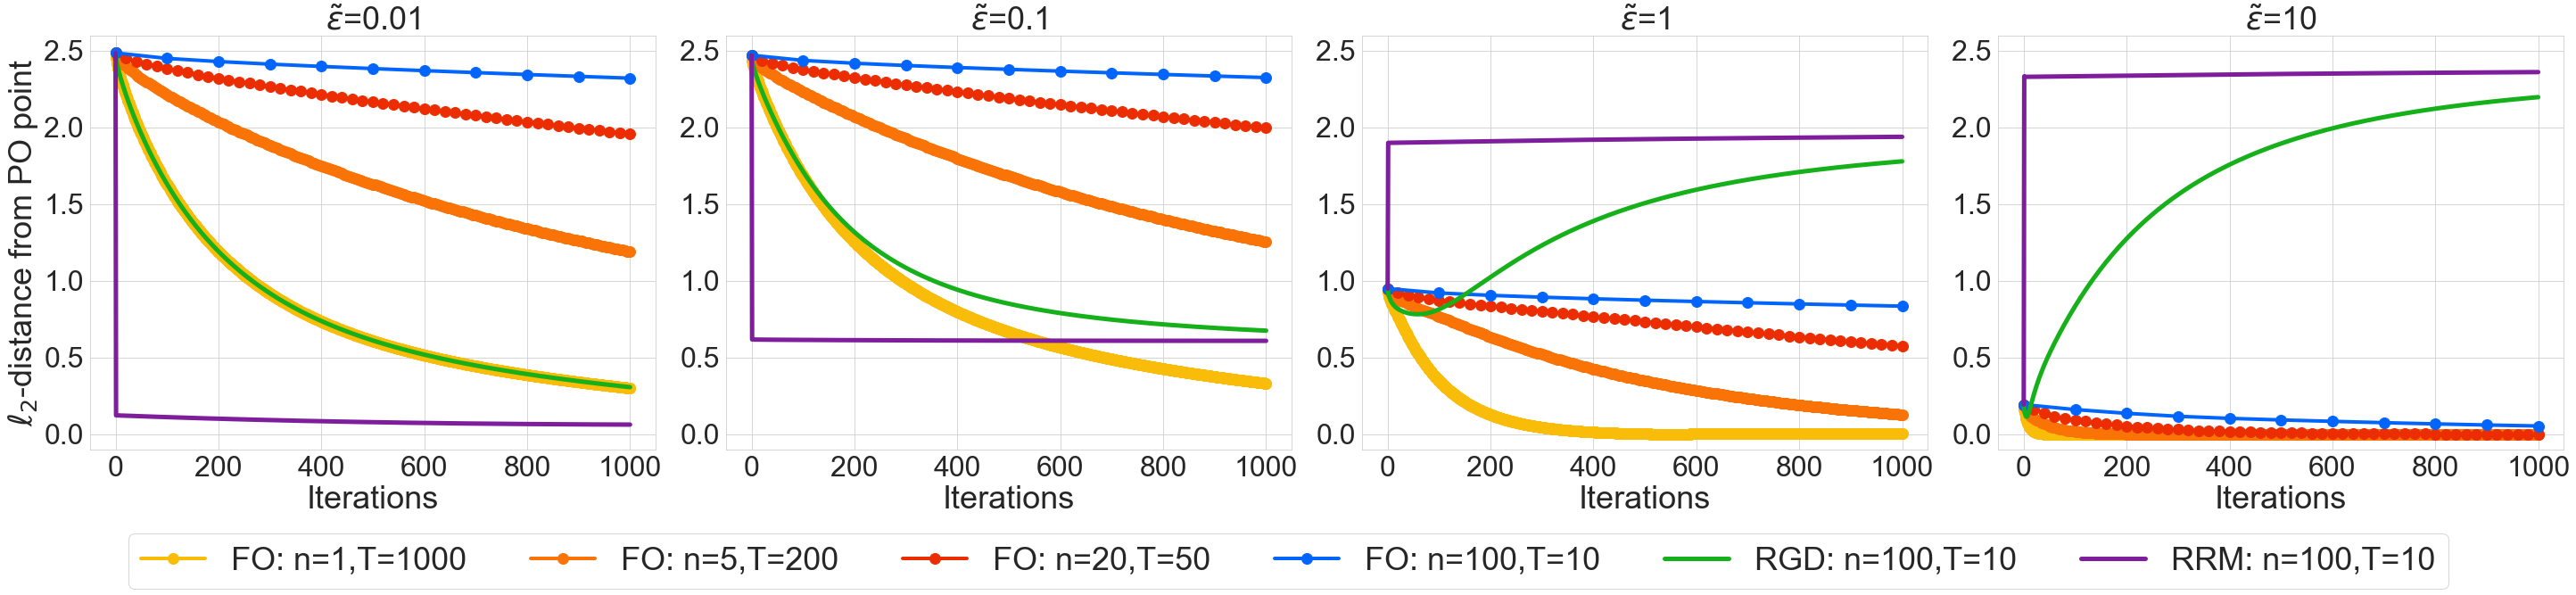

In [146]:
fig, axs = plt.subplots(1, 4, figsize=(40, 8), constrained_layout=True, sharey=False)
palette = ['xkcd:golden rod', 'xkcd:orange', 'xkcd:tomato red', 'xkcd:bright blue', 'xkcd:green', 'xkcd:purple'] #sns.color_palette("tab10", 5)

index = 0
for epsilon in epsilon_lst:
    ci = 0
    for pair in pairs:
        n, T = pair
        x_coords = range(0, n*T + 1, n)
        x_coords = range(0, n*T + 1, n)
        markersize=12
        if index == 0:
            axs[index].plot(x_coords, fo_info[epsilon][pair][0], '-o', color=palette[ci], markersize=markersize, label="FO: n={},T={}".format(n, T), linewidth=4)
        else:
            axs[index].plot(x_coords, fo_info[epsilon][pair][0], '-o', color=palette[ci], markersize=markersize, linewidth=4)
        ci += 1
    if index == 0:
        axs[index].plot(rgd_info[epsilon][0], color=palette[ci], label="RGD: n={},T={}".format(n, T), linewidth=5)
        ci += 1
        axs[index].plot(rrm_info[epsilon][0], color=palette[ci], label="RRM: n={},T={}".format(n, T), linewidth=5)
    else:
        axs[index].plot(rgd_info[epsilon][0], color=palette[ci], linewidth=5)
        ci += 1
        axs[index].plot(rrm_info[epsilon][0], color=palette[ci], linewidth=5)
    axs[index].set_xlabel("Iterations", fontsize=36)
    if index==0:
        axs[index].set_ylabel("$\ell_2$-distance from PO point", fontsize=36)
    axs[index].set_ylim(-0.1, 2.6)
    axs[index].set_title(r"$\tilde{\epsilon}$="+str(epsilon), fontsize=36)
    axs[index].tick_params(labelsize=32)
    index += 1
fig.legend(fontsize=36, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6)
for tag in ['png','pdf']:
    fig.savefig('./figs/givemecredit_epoch.'+tag,transparent=True,dpi=300, bbox_inches='tight')

## Experiment 2 from appendix D.5

In [148]:
base_theta = np.zeros(num_features)
epsilon_lst = [0.01, 0.1, 1, 10]

# Experiments 2
pairs = [(10,10000),(100,1000)]


delta = 0.9
R = 10
T = 1000



for epsilon in epsilon_lst:
    po_point, po_loss = compute_po_point(epsilon, base_features, base_labels, l2_penalty)
    po_info[epsilon] = (po_point, po_loss)

In [149]:
rgd_info = dict() 
pairs = [(10,10000),(100,1000)]
for epsilon in epsilon_lst:
    rgd_info[epsilon] = dict()
    for pair in pairs:
        base_theta = np.zeros(num_features)
        n, T = pair
        rgd_distances, rgd_thetas = repeated_gradient_descent_epoch(base_theta, epsilon,  n=n, T=T, delta=delta, po_point=po_info[epsilon][0], R=R)
        rgd_info[epsilon][pair] = (rgd_distances, rgd_thetas)

(10, 10000) 0.01
(100, 1000) 0.01
(10, 10000) 0.1
(100, 1000) 0.1
(10, 10000) 1
(100, 1000) 1
(10, 10000) 10
(100, 1000) 10


In [150]:
rrm_info = dict() 
pairs = [(10,10000),(100,1000)]
for epsilon in epsilon_lst:
    rrm_info[epsilon] = dict()
    for pair in pairs:
        n, T = pair
        rrm_distances, rrm_thetas = repeated_risk_minimization_epoch(base_theta, epsilon, n=n, T=T, delta=delta,po_point= po_info[epsilon][0])
        rrm_info[epsilon][pair] = (rrm_distances, rrm_thetas)

(10, 10000) 0.01
(100, 1000) 0.01
(10, 10000) 0.1
(100, 1000) 0.1
(10, 10000) 1
(100, 1000) 1
(10, 10000) 10
(100, 1000) 10


In [151]:
fo_info = dict() 
pairs = [(10,10000),(100,1000)]
for epsilon in epsilon_lst:
    fo_info[epsilon] = dict()
    for pair in pairs:
        n, T = pair
        fo_distances, fo_thetas = fo(base_theta, epsilon, n, T, delta, po_info[epsilon][0], R)
        fo_info[epsilon][pair] = (fo_distances, fo_thetas)

0.01 (10, 10000)
0.01 (100, 1000)
0.1 (10, 10000)
0.1 (100, 1000)
1 (10, 10000)
1 (100, 1000)
10 (10, 10000)
10 (100, 1000)


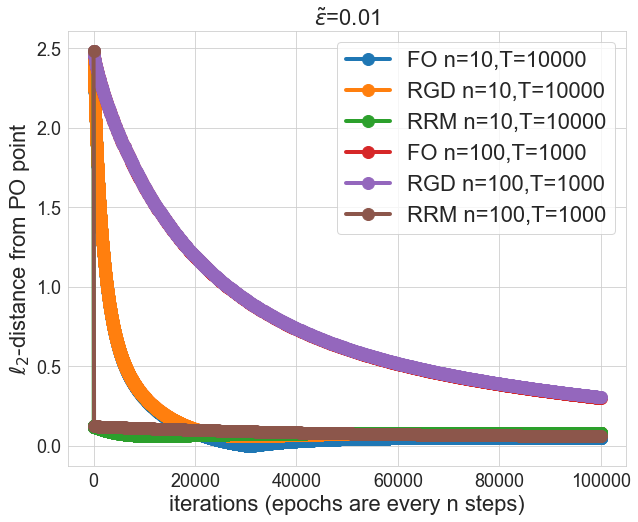

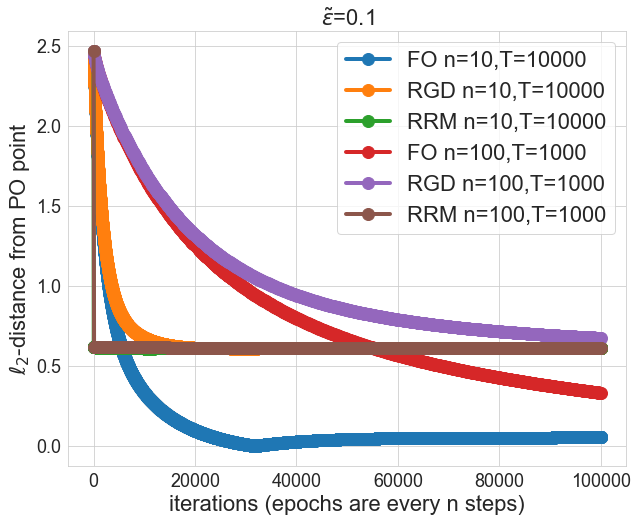

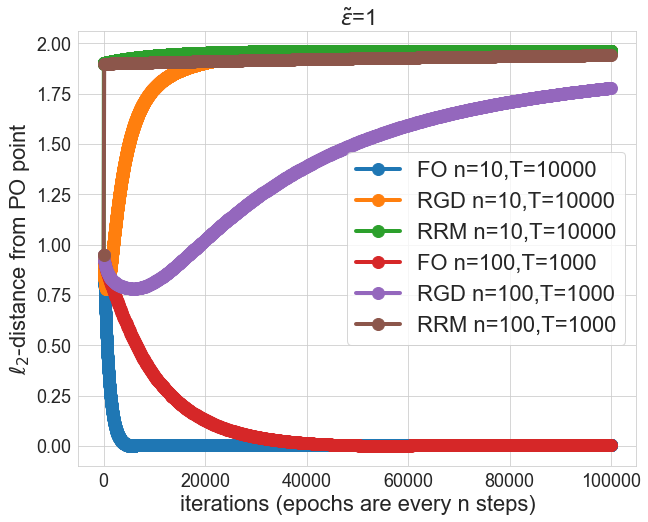

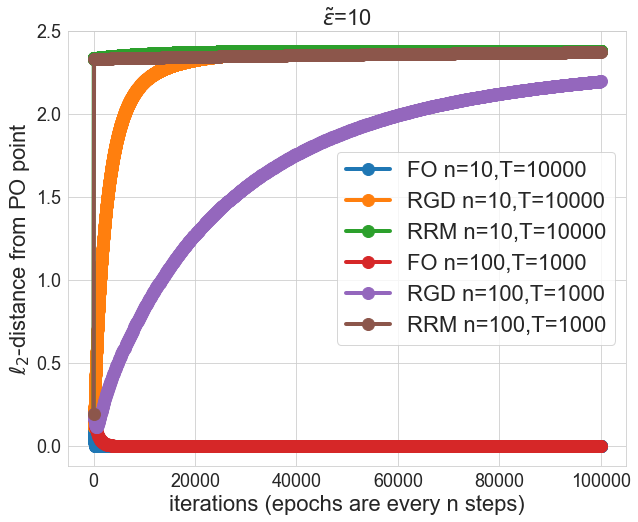

In [92]:
for epsilon in epsilon_lst:
    plt.figure(figsize=(10,8))

    for pair in pairs:
        n, T = pair
        x_coords = range(0, n*T + 1, n)
        plt.plot(x_coords, fo_info[epsilon][pair][0], label="FO n={},T={}".format(n, T), linewidth=4, marker='o', markersize=12)
        plt.plot(x_coords,rgd_info[epsilon][pair][0], label="RGD n={},T={}".format(n, T), linewidth=4, marker='o', markersize=12)
        plt.plot(x_coords,rrm_info[epsilon][pair][0], label="RRM n={},T={}".format(n, T), linewidth=4, marker='o', markersize=12)

    plt.xlabel("iterations (epochs are every n steps)", fontsize=22)
    plt.ylabel(r"$\ell_2$-distance from PO point", fontsize=22)
    plt.title(r"$\tilde{\epsilon}}$="+str(epsilon), fontsize=22)
    plt.tick_params(labelsize=18)
    plt.legend(fontsize=22)
    plt.show()

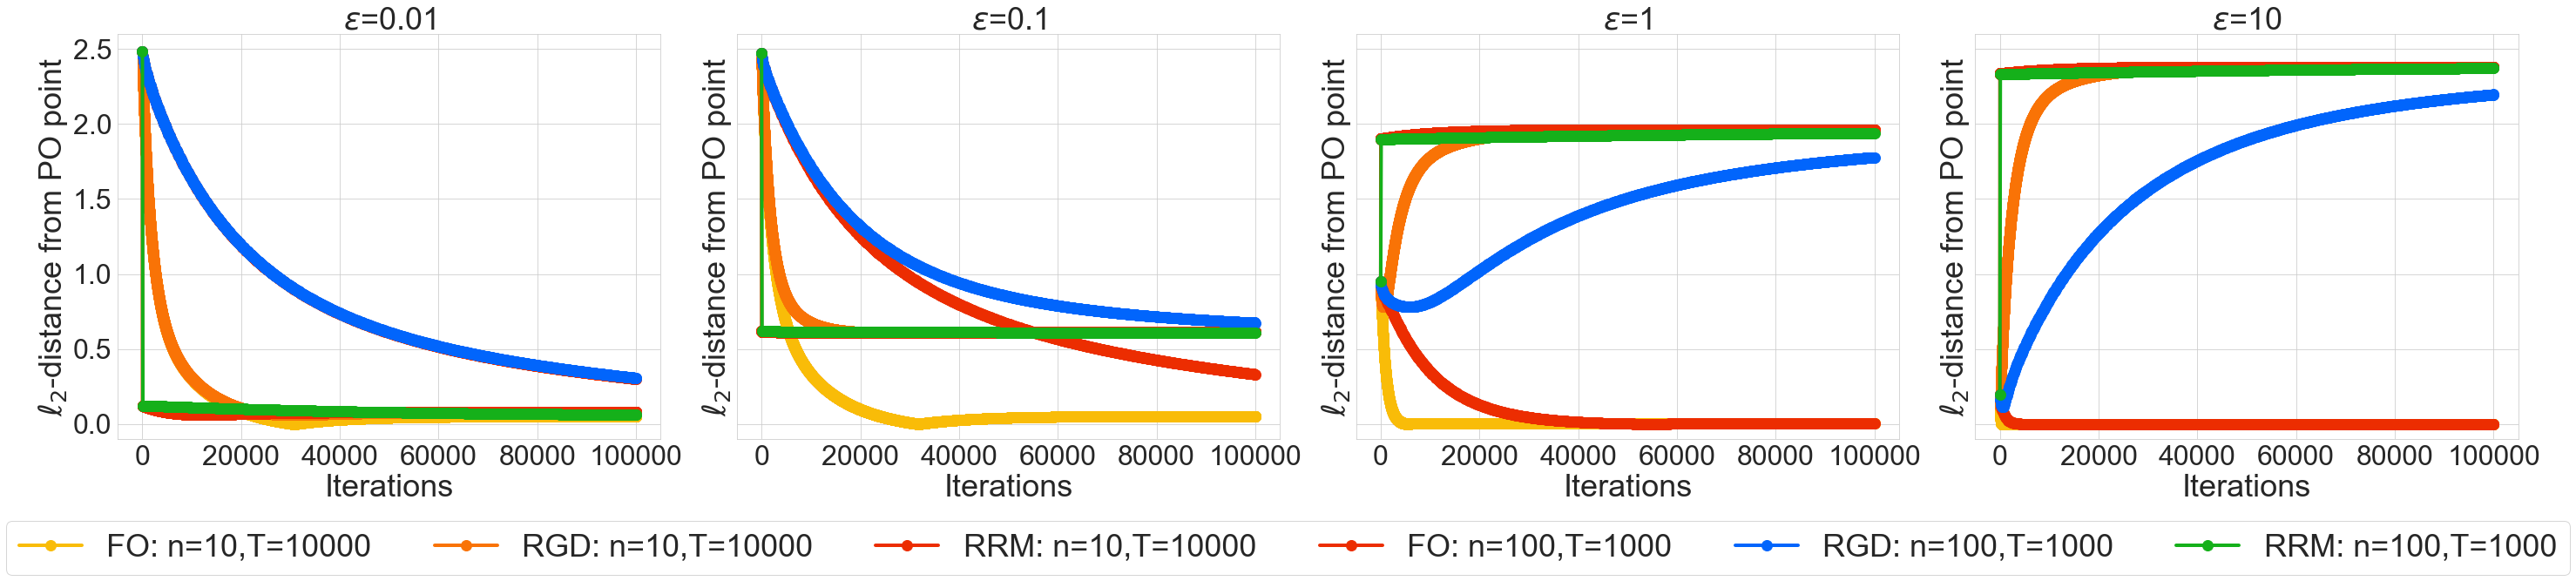

In [105]:
fig, axs = plt.subplots(1, 4, figsize=(40, 8), constrained_layout=True, sharey=False)

index = 0
for epsilon in epsilon_lst:
    ci = 0
    for pair in pairs:
        n, T = pair
        x_coords = range(0, n*T + 1, n)
        x_coords = range(0, n*T + 1, n)
        markersize=12
        if index == 0:
            axs[index].plot(x_coords, fo_info[epsilon][pair][0], '-o', color=palette[ci], markersize=markersize, label="FO: n={},T={}".format(n, T), linewidth=4)
        else:
            axs[index].plot(x_coords, fo_info[epsilon][pair][0], '-o', color=palette[ci], markersize=markersize, linewidth=4)
        ci += 1
        if index == 0:
            axs[index].plot(x_coords,rgd_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, label="RGD: n={},T={}".format(n, T), linewidth=4)
            ci += 1
            axs[index].plot(x_coords,rrm_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, label="RRM: n={},T={}".format(n, T), linewidth=4)
        else:
            axs[index].plot(x_coords,rgd_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, linewidth=4)
            ci += 1
            axs[index].plot(x_coords,rrm_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, linewidth=4)
    axs[index].set_xlabel("Iterations", fontsize=36)
    if index==0:
        axs[index].set_ylabel("$\ell_2$-distance from PO point", fontsize=36)
    axs[index].set_ylim(-0.1, 2.6)
    axs[index].set_title("$\tilde{\epsilon}$="str(epsilon), fontsize=36)
    axs[index].tick_params(labelsize=32)
    index += 1
fig.legend(fontsize=36, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6)
fig.savefig('./figs/givemecredit_epoch.pdf', bbox_inches='tight')

10 10000
10 10000
10 10000
10 10000


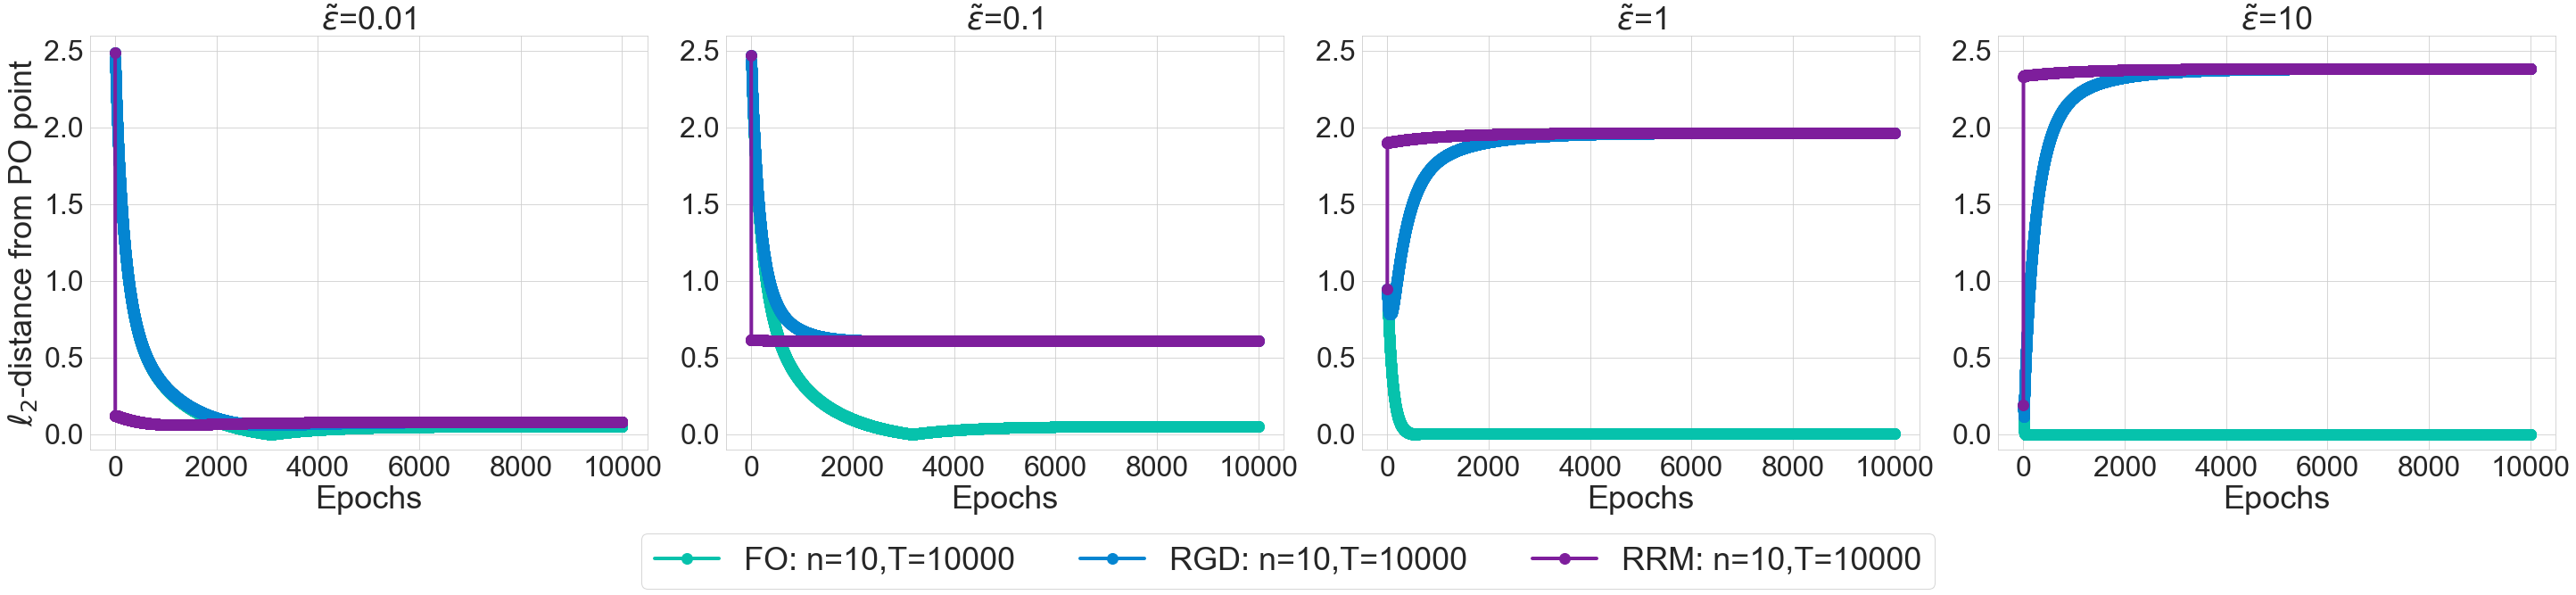

In [127]:
fig, axs = plt.subplots(1, 4, figsize=(40, 8), constrained_layout=True, sharey=False)
palette=['xkcd:turquoise','xkcd:cerulean','xkcd:purple']
index = 0
for epsilon in epsilon_lst:
    ci = 0
    for pair in [pairs[0]]:
        n, T = pair
        x_coords = range(0, T+1, 1)
        print(n,T)
        markersize=12
        if index == 0:
            axs[index].plot(x_coords, fo_info[epsilon][pair][0], '-o', color=palette[ci], markersize=markersize, label="FO: n={},T={}".format(n, T), linewidth=4)
        else:
            axs[index].plot(x_coords, fo_info[epsilon][pair][0], '-o', color=palette[ci], markersize=markersize, linewidth=4)
        ci += 1
        if index == 0:
            axs[index].plot(x_coords,rgd_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, label="RGD: n={},T={}".format(n, T), linewidth=4)
            ci += 1
            axs[index].plot(x_coords,rrm_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, label="RRM: n={},T={}".format(n, T), linewidth=4)
        else:
            axs[index].plot(x_coords,rgd_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, linewidth=4)
            ci += 1
            axs[index].plot(x_coords,rrm_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, linewidth=4)
    axs[index].set_xlabel("Epochs", fontsize=36)
    if index==0:
        axs[index].set_ylabel("$\ell_2$-distance from PO point", fontsize=36)
    axs[index].set_ylim(-0.1, 2.6)
    axs[index].set_title(r"$\tilde{\epsilon}$="+str(epsilon), fontsize=36)
    axs[index].tick_params(labelsize=32)
    index += 1
fig.legend(fontsize=36, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6)
for tag in ['png','pdf']:
    fig.savefig('./figs/givemecredit_epoch_n=10_T=10000.'+tag,transparent=True,dpi=300, bbox_inches='tight')

In [110]:
len(fo_info[0.01][(10,10000)][0])

10001

100 1000
100 1000
100 1000
100 1000


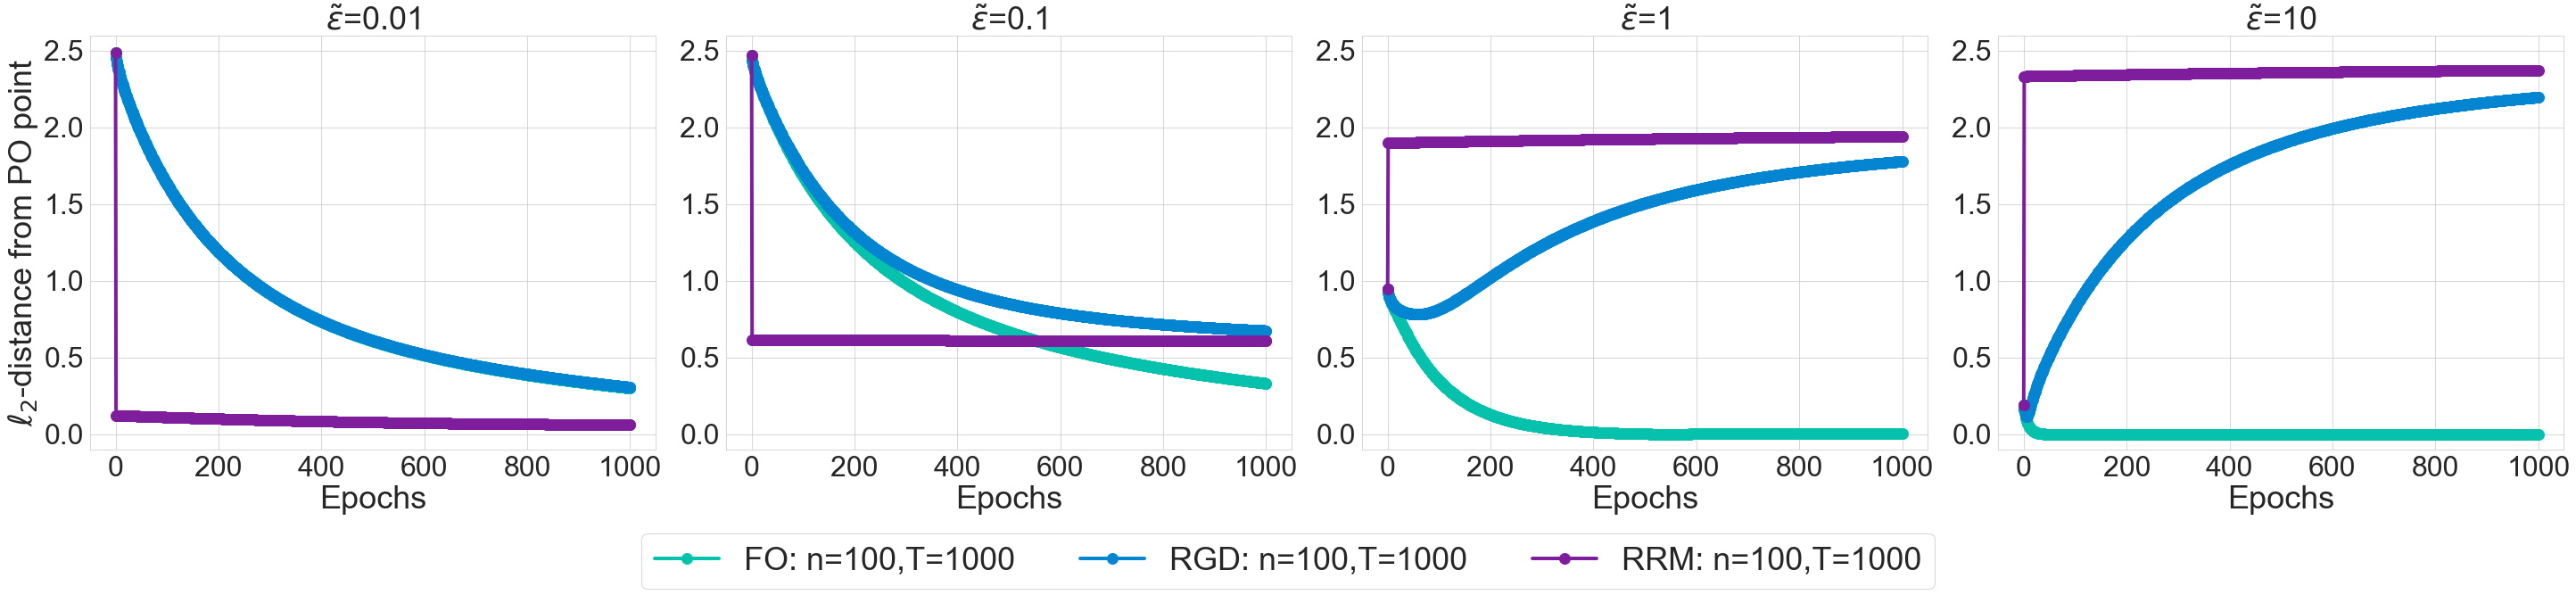

In [126]:
fig, axs = plt.subplots(1, 4, figsize=(40, 8), constrained_layout=True, sharey=False)
palette=['xkcd:turquoise','xkcd:cerulean','xkcd:purple']
index = 0
for epsilon in epsilon_lst:
    ci = 0
    for pair in [pairs[1]]:
        n, T = pair
        x_coords = range(0, T+1, 1)
        print(n,T)
        markersize=12
        if index == 0:
            axs[index].plot(x_coords, fo_info[epsilon][pair][0], '-o', color=palette[ci], markersize=markersize, label="FO: n={},T={}".format(n, T), linewidth=4)
        else:
            axs[index].plot(x_coords, fo_info[epsilon][pair][0], '-o', color=palette[ci], markersize=markersize, linewidth=4)
        ci += 1
        if index == 0:
            axs[index].plot(x_coords,rgd_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, label="RGD: n={},T={}".format(n, T), linewidth=4)
            ci += 1
            axs[index].plot(x_coords,rrm_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, label="RRM: n={},T={}".format(n, T), linewidth=4)
        else:
            axs[index].plot(x_coords,rgd_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, linewidth=4)
            ci += 1
            axs[index].plot(x_coords,rrm_info[epsilon][pair][0],'-o', color=palette[ci],markersize=markersize, linewidth=4)
    axs[index].set_xlabel("Epochs", fontsize=36)
    if index==0:
        axs[index].set_ylabel("$\ell_2$-distance from PO point", fontsize=36)
    axs[index].set_ylim(-0.1, 2.6)
    axs[index].set_title(r"$\tilde{\epsilon}$="+str(epsilon), fontsize=36)
    axs[index].tick_params(labelsize=32)
    index += 1
fig.legend(fontsize=36, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6)
for tag in ['png','pdf']:
    fig.savefig('./figs/givemecredit_epoch_n=100_T=1000.'+tag,transparent=True,dpi=300, bbox_inches='tight')